# Определение перспективного тарифа для телеком-компании


Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

## Изучение данных из файлов

In [1]:
import pandas as pd
import math
import numpy as np 
from scipy import stats as st
import matplotlib.pyplot as plt
from IPython.display import display

calls = pd.read_csv('/datasets/calls.csv') 
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')
display(calls.head(5), internet.head(5), messages.head(5), tariffs.head(5), users.head(5)) 
calls.info()
internet.info()
messages.info()
tariffs.info()
users.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
<class 'pandas.core.frame.DataFrame'>
Rang

### Вывод
Мы открыли 5 файлов и изучили их. 
В файлах calls,  messages, tariffs нет пропусков, файл открывается корректно. В файле internet нет пропусков, файл открывается корректно, но есть ненужный столбец, попробуем удалить его в дальнейшем. В файле users есть пропуски в столбце churn_date, оставим их как есть, так как это значит что пользователь еще пользуется тарифом, файл открывается корректно.

## Предобработка данных

In [2]:
#calls: округлим значения в столбце duration в большую сторону, тип автоматически станет int64
calls['duration'] = calls['duration'].apply(math.ceil)
display(calls.head(5))
calls.info()

#internet: значения в столбце mb_used оставим как есть, округлим их после группировки, также удалим лишний столбец
internet.drop('Unnamed: 0', axis=1, inplace=True)
display(internet.head(5))
internet.info()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0,1000
1,1000_1,2018-08-17,0,1000
2,1000_2,2018-06-11,3,1000
3,1000_3,2018-09-21,14,1000
4,1000_4,2018-12-15,6,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null int64
user_id      202607 non-null int64
dtypes: int64(2), object(2)
memory usage: 6.2+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


### Вывод
Мы привели данные в порядок и к нужным типам. В файле calls округлили значения в столбце duration в большую сторону с помощью math.ceil, в internet удалили лишний столбец.

In [3]:
# добавим столбец месяц в таблицу calls с помощью pd.to_datetime(calls и dt.month
calls['month'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d').dt.month

# количество сделанных звонков и израсходованных минут по месяцам 
# заодно переименуем названия столбцов для удобства с помощью rename()
user_calls = calls.groupby(['user_id', 'month'])\
    .agg({'duration':'sum', 'id':'count'}).reset_index()
user_calls = user_calls.rename(
    columns={'duration': 'minutes', 'id': 'number_of_calls'}) 
display(user_calls.head(5))

,user_id,month,minutes,number_of_calls
0,1000,5,159,22
1,1000,6,172,43
2,1000,7,340,47
3,1000,8,408,52
4,1000,9,466,58


In [4]:
# добавим столбец месяц в таблицу messages с помощью pd.to_datetime и dt.month
messages['month'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d').dt.month
# количество отправленных сообщений по месяцам
user_messages = messages.groupby(['user_id', 'month'])\
    .agg({'id':'count'}).reset_index()
user_messages = user_messages.rename(
    columns={'id': 'number_of_messages'}) 
display(user_messages.head(5))

,user_id,month,number_of_messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


In [5]:
# добавим столбец месяц в таблицу internet с помощью pd.to_datetime и dt.month
internet['month'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d').dt.month

# количество потраченных мегабайт по месяцам
user_internet = internet.groupby(['user_id', 'month'])\
    .agg({'mb_used':'sum'}).reset_index()
user_internet = user_internet.rename(
    columns={'id': 'number_of_mb'})
display(user_internet.head(5))

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [6]:
# попробуем объединить всё в одну таблицу
user_c_m = user_calls.merge(user_messages, on=['user_id', 'month'], how='outer')
user_c_m_i = user_c_m.merge(user_internet, on=['user_id', 'month'], how='outer')
#display(user_c_m_i.head(5))

#присоединяем таблицы пользователей и тарифов, чтобы под рукой была вся информация
user_all = user_c_m_i.merge(users, on='user_id', how='left')
tariffs = tariffs.rename(
    columns={'tariff_name': 'tariff'})
user_all = user_all.merge(tariffs, on='tariff', how='left')
display(user_all.head(5))

,user_id,month,minutes,number_of_calls,number_of_messages,mb_used,age,churn_date,city,first_name,last_name,reg_date,tariff,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,159.0,22.0,22.0,2253.49,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,1000,6,172.0,43.0,60.0,23233.77,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,1000,7,340.0,47.0,75.0,14003.64,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,1000,8,408.0,52.0,81.0,14055.93,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,1000,9,466.0,58.0,57.0,14568.91,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


In [7]:
# найдем помесячную выручку с каждого пользователя
# сначала найдем перерасход по каждой услуге
user_all['minutes_overrun']  = user_all['minutes'] - user_all['minutes_included']
user_all['messages_overrun'] = user_all['number_of_messages'] - user_all['messages_included']
user_all['mb_used_overrun']  = user_all['mb_used'] - user_all['mb_per_month_included']

#переведем перерасход в гигабайты и округлим в большую сторону
user_all['mb_used_overrun'] = np.ceil(user_all['mb_used_overrun']/1024)
display(user_all.head(5))

,user_id,month,minutes,number_of_calls,number_of_messages,mb_used,age,churn_date,city,first_name,...,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,mb_used_overrun
0,1000,5,159.0,22.0,22.0,2253.49,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2841.0,-978.0,-27.0
1,1000,6,172.0,43.0,60.0,23233.77,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2828.0,-940.0,-7.0
2,1000,7,340.0,47.0,75.0,14003.64,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2660.0,-925.0,-16.0
3,1000,8,408.0,52.0,81.0,14055.93,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2592.0,-919.0,-16.0
4,1000,9,466.0,58.0,57.0,14568.91,52,NaN,Краснодар,Рафаил,...,1000,30720,3000,1950,150,1,1,-2534.0,-943.0,-15.0


In [8]:
# создадим функцию для подсчета перерасхода в рублях

def get_revenue(row):
    revenue_by_min = 0
    revenue_by_messages = 0
    revenue_mb = 0
    if row['minutes_overrun'] > 0:
        revenue_by_min = row['minutes_overrun'] * row['rub_per_minute']
    if row['messages_overrun'] > 0:
        revenue_by_messages = row['messages_overrun'] * row['rub_per_message']
    if row['mb_used_overrun'] > 0:
        revenue_mb = row['mb_used_overrun'] * row['rub_per_gb']
    result = revenue_by_min + revenue_by_messages + revenue_mb
    return result

# добавим столбец с перерасходом в таблицу
user_all['revenue'] = user_all.apply(get_revenue, axis=1)

#посчитаем помесячную выручку с каждого пользователя
user_all['revenue_total'] = user_all['rub_monthly_fee'] + user_all['revenue']
display(user_all.head(10))

,user_id,month,minutes,number_of_calls,number_of_messages,mb_used,age,churn_date,city,first_name,...,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,minutes_overrun,messages_overrun,mb_used_overrun,revenue,revenue_total
0,1000,5,159.0,22.0,22.0,2253.49,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,-2841.0,-978.0,-27.0,0.0,1950.0
1,1000,6,172.0,43.0,60.0,23233.77,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,-2828.0,-940.0,-7.0,0.0,1950.0
2,1000,7,340.0,47.0,75.0,14003.64,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,-2660.0,-925.0,-16.0,0.0,1950.0
3,1000,8,408.0,52.0,81.0,14055.93,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,-2592.0,-919.0,-16.0,0.0,1950.0
4,1000,9,466.0,58.0,57.0,14568.91,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,-2534.0,-943.0,-15.0,0.0,1950.0
5,1000,10,350.0,57.0,73.0,14702.49,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,-2650.0,-927.0,-15.0,0.0,1950.0
6,1000,11,338.0,43.0,58.0,14756.47,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,-2662.0,-942.0,-15.0,0.0,1950.0
7,1000,12,333.0,46.0,70.0,9817.61,52,NaN,Краснодар,Рафаил,...,3000,1950,150,1,1,-2667.0,-930.0,-20.0,0.0,1950.0
8,1001,11,430.0,59.0,NaN,18429.34,41,NaN,Москва,Иван,...,500,550,200,3,3,-70.0,NaN,3.0,600.0,1150.0
9,1001,12,414.0,63.0,NaN,14036.66,41,NaN,Москва,Иван,...,500,550,200,3,3,-86.0,NaN,-1.0,0.0,550.0


### Вывод
Мы посчитали для каждого пользователя количесто звонков, израсходованных минут, отправленных сообщений и потраченных мегабайт. С помощью этой информации мы смогли посчитать помесячную выручку с каждого пользователя и обнаружили, что некоторые пользователи превышают отведенный в тарифе лимит.

## Анализ данных

In [9]:
#Посчитаем сколько тратит клиент за месяц минут, смс и мегабайт.

# 1. сколько минут разговора
print(user_all.groupby('tariff')['minutes'].mean())        
print()
# 2. сколько сообщений 
print(user_all.groupby('tariff')['number_of_messages'].mean()) 
print()
# 3.какой объем интернет-трафика
print(user_all.groupby('tariff')['mb_used'].mean()/1024)

tariff
smart    419.062978
ultra    545.451104
Name: minutes, dtype: float64

tariff
smart    38.716441
ultra    61.161006
Name: number_of_messages, dtype: float64

tariff
smart    15.835607
ultra    19.207505
Name: mb_used, dtype: float64


### Вывод
Мы видим, что пользователи тарифа «Смарт» в среднем тратят 419 минут в месяц при лимите в 500 мин,
в то время как пользователи тарифа «Ультра» 545 при норме в 3000 мин.

Сообщения:
«Смарт» - 39 шт. при лимите в 50,
«Ультра» - 61 шт. при лимите в 1000.

Интернет-трафик:
«Смарт» - 16 Гб при лимите в 15,
«Ультра» - 19 при лимите в 30.

In [10]:
#посчитаем стандартное отклонение

# 1. минут
print(user_all.groupby('tariff')['minutes'].std())        
print()
# 2. сообщений 
print(user_all.groupby('tariff')['number_of_messages'].std()) 
print()
# 3.интернет-трафика
print(user_all.groupby('tariff')['mb_used'].std())

tariff
smart    189.325618
ultra    306.925754
Name: minutes, dtype: float64

tariff
smart    26.787949
ultra    45.931026
Name: number_of_messages, dtype: float64

tariff
smart    5861.736234
ultra    9943.050284
Name: mb_used, dtype: float64


In [11]:
user_all.pivot_table(index='tariff',  
                 values=['minutes', 'mb_used', 'number_of_messages'], 
                 aggfunc=['mean', 'std', 'var']).T.style.format('{:.2f}')

In [12]:
# посчитаем дисперсию

# 1. минут
print(user_all.groupby('tariff')['minutes'].std()** 2)        
print()
# 2. сообщений 
print(user_all.groupby('tariff')['number_of_messages'].std()** 2) 
print()
# 3.интернет-трафика
print(user_all.groupby('tariff')['mb_used'].std()** 2)


tariff
smart    35844.189551
ultra    94203.418396
Name: minutes, dtype: float64

tariff
smart     717.594201
ultra    2109.659183
Name: number_of_messages, dtype: float64

tariff
smart    3.435995e+07
ultra    9.886425e+07
Name: mb_used, dtype: float64


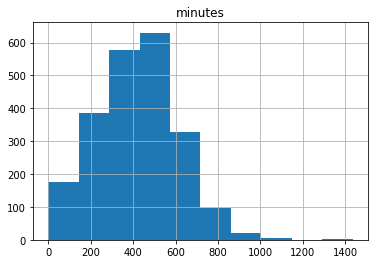

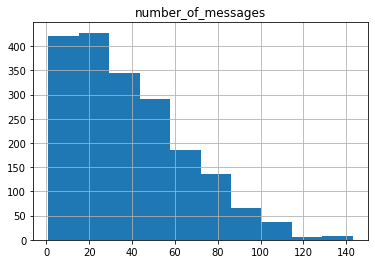

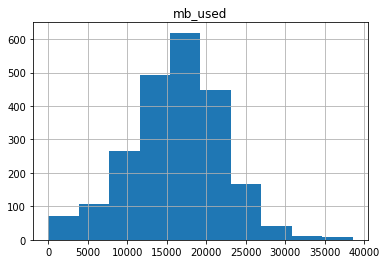

In [13]:
# построим гистограммы

# построим гистограммы для тарифа Смарт с исползованием цикла!
plot_columns = [
    'minutes',
    'number_of_messages',
    'mb_used'
]

for col in plot_columns:
    user_all[user_all['tariff']=='smart'][col].hist()
    plt.title(col)
    plt.show()


### Вывод
Изучив гистограммы тарифа "Смарт" мы видим, что распределение количества минут и интернет-трафика нормальное. Распределение сообщений скошено влево, обычно пользователи используют от 0 до 30 смс в месяц.

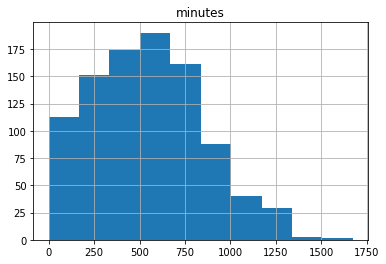

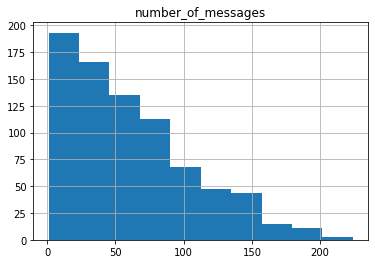

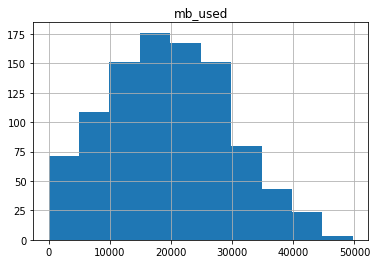

In [14]:
# построим гистограммы для тарифа Смарт с исползованием цикла!
plot_columns = [
    'minutes',
    'number_of_messages',
    'mb_used'
]

for col in plot_columns:
    user_all[user_all['tariff']=='ultra'][col].hist()
    plt.title(col)
    plt.show()

### Вывод
В целом у тарифа "Ультра" картина схожая с тарифом "Смарт". 

## Проверим гипотезы

### Гипотеза № 1
Средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.

In [15]:
# создадим две таблицы по тарифам
smart = user_all[user_all['tariff'] == 'smart']
ultra = user_all[user_all['tariff'] == 'ultra']
print(smart.groupby('month')['revenue_total'].mean())
print()
print(ultra.groupby('month')['revenue_total'].mean())
print()
# проверим гипотезу
alpha = 0.05
results = st.ttest_ind(smart.groupby('month')['revenue_total'].mean()\
                       , ultra.groupby('month')['revenue_total'].mean(), equal_var = False)

print('P-value:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

month
1      721.323529
2      827.603448
3     1164.623377
4      963.089286
5     1197.510638
6     1204.018293
7     1223.950249
8     1320.595745
9     1249.946154
10    1364.853741
11    1343.047468
12    1578.531157
Name: revenue_total, dtype: float64

month
1     1950.000000
2     1975.000000
3     2014.864865
4     2001.818182
5     2059.701493
6     2039.285714
7     2118.131868
8     2083.177570
9     2024.347826
10    2065.853659
11    2092.164179
12    2138.848921
Name: revenue_total, dtype: float64

P-value: 3.2027925855703315e-08
Отвергаем нулевую гипотезу


In [16]:
print(user_all[user_all['tariff'] == 'smart']['revenue_total'].mean())
print(user_all[user_all['tariff'] == 'ultra']['revenue_total'].mean())
# проверим гипотезу
alpha = 0.05
results = st.ttest_ind(user_all[user_all['tariff'] == 'smart']['revenue_total']\
                       , user_all[user_all['tariff'] == 'ultra']['revenue_total'], equal_var = False)

print('P-value:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1289.9735307312696
2070.1522842639592
P-value: 4.2606313931076085e-250
Отвергаем нулевую гипотезу


### Вывод
Нулевая гипотеза - срдняя выручка тарифов равна, алтернативная - выручки отличаются.

Мы выбрали гипотезу о равенстве средних двух генеральных совокупностей,значит используем st.ttest_ind, alpha возьмем 0.05, то есть вероятность 5 %.
Наша вероятность оказалось намного меньше процента, значит мы отвергаем нулевую гипотезу. Срдние выручки различаются.

Выручка тарифа «Ультра» больше, но зато у тарифа «Смарт» больше плата за перерасход лимитов.

### Гипотеза № 2
Средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

In [17]:
#создадим две таблицы, для клиентов из москвы и остальных
moscow = user_all[user_all['city'] == 'Москва']
other = user_all[user_all['city'] != 'Москва']
print(moscow.groupby('month')['revenue_total'].mean())
print()
print(other.groupby('month')['revenue_total'].mean())
print()

# проверим гипотезу
alpha = 0.05
results = st.ttest_ind(moscow.groupby('month')['revenue_total'].mean()\
                       , other.groupby('month')['revenue_total'].mean(), equal_var = False)

print('P-value:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

month
1     1475.000000
2     1175.142857
3     1649.600000
4     1503.310345
5     1465.128205
6     1500.723404
7     1448.571429
8     1600.709677
9     1548.544118
10    1547.790123
11    1575.175824
12    1647.406250
Name: revenue_total, dtype: float64

month
1      865.000000
2     1161.014706
3     1396.106383
4     1263.550725
5     1477.568047
6     1483.706468
7     1515.440678
8     1549.985714
9     1473.892508
10    1577.369048
11    1563.821727
12    1766.089474
Name: revenue_total, dtype: float64

P-value: 0.27212244216705705
Не получилось отвергнуть нулевую гипотезу


In [18]:
print(user_all[user_all['city'] == 'Москва']['revenue_total'].mean())
print(user_all[user_all['city'] != 'Москва']['revenue_total'].mean())
# проверим гипотезу
alpha = 0.05
results = st.ttest_ind(user_all[user_all['city'] == 'Москва']['revenue_total']\
                       , user_all[user_all['city'] != 'Москва']['revenue_total'], equal_var = False)

print('P-value:', results.pvalue)
if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

1546.7135842880523
1524.9362274298885
P-value: 0.5257376663729298
Не получилось отвергнуть нулевую гипотезу


### Вывод
Нулевая гипотеза - средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов. Альтернативная - различаются.

Мы выбрали гипотезу о равенстве средних двух генеральных совокупностей,значит используем st.ttest_ind, alpha возьмем 0.05, то есть вероятность 5 %.
Наша вероятность оказалось 0.53, то есть 53 %, значит мы не можем отвергнуть нулевую гипотезу.

## Общий вывод
Нам были предоставлены данные 500 пользователей, использующих тарифа "Смарт" и "Ультра". Данные были в 5 таблицах. Мы изучили таблицы, привели данные к нужны типам, исправили ошибки и собрали всю информацию в 1 таблицу.
Затем нашли данные за месяц по количеству израсходованных минут, сообщений, интернет-трафика и помесячную выручку каждого пользователя. Построили гистограммы тарифов и заметили на них нормальное распределение количества звонков и трафика и скошенное влево распределение сообщений на обоих тарифах.
Проверили две гипотезы. Первая о том, что прибыли в тарифах различаются и она оказалась верной.
Прибыль с тарифа "Ультра" оказалась выше чем с тарифа " Смарт", но только за счет того, что у первого стоимость в 3.5 раза больше, зато в тарифе "Смарт" пользователи чаще и больше платят за перерасход лимитов. 
Вторую гипотезу о том, что в Москве прибыль больше чем в регионах доказать не удалось. Москва не так уж сильно отличается от регионов.

Считаю наиболее выгодным для оператора тариф "Ультра", в среднем доход с одного пользователя тарифа "Ультра" почти на 800 р больше пользователя тарифа "Смарт". Также считаю оператору стоит задуматься о вводе нового тарифа, занимающего среднюю нишу между первыми двумя, так как у пользователей "Смарт" большая переплата, но 1950 р в месяц они платить не готовы. Я бы предложил тариф под кодовым названием "Оптима" и абонентской платой порядка 1050-1150 р.